# How to transform the input and output of a subgraph

- Author: [BokyungisaGod](https://github.com/BokyungisaGod)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview
The **state** of a `subgraph` can be completely independent of the state of the `parent graph`.
This means that the two graphs can operate in isolation, with no direct sharing or dependency on specific state keys. In other words, there may be no overlapping state keys between the two graphs, making it necessary to bridge the gap between their respective states for seamless execution.


In such cases, the input should be transformed before invoking the `subgraph` to ensure compatibility, and the output should be transformed back into the format expected by the `parent graph` before returning. This transformation process acts as a connector, allowing the independent components to interact without modifying their internal structures or logic. By doing so, we maintain the modularity and flexibility of each graph while enabling efficient communication between them.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Definitions of graph and subgraph](#definitions-of-graph-and-subgraph)
- [Definition of grandchild](#definition-of-grandchild)
- [Definition of child](#definition-of-child)
- [Definition of parent](#definition-of-parent)

### References

- [LangChain](https://blog.langchain.dev/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "",  # set the project name same as the title
        }
    )

## Definitions of `graph` and `subgraph`

We will define the following three `graphs`:

- `parent graph`

- `child subgraph` invoked by the `parent graph`

- `grandchild subgraph` invoked by the `child graph`

## Definition of `grandchild`
The `grandchild` is the smallest unit in the hierarchical structure of our graph system. It operates independently of the `child` and `parent graphs` and processes its unique `state`. By defining the `grandchild graph` and its `state` transformations, we ensure modularity and reusability within the larger system.

In [5]:
# Import modules for state management using TypedDict and StateGraph
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END


# Define a TypedDict class for the state of the grandchild node, including a string-type my_grandchild_key
class GrandChildState(TypedDict):
    my_grandchild_key: str


# Function to handle the state of grandchild nodes and add greetings to the input string
def grandchild_1(state: GrandChildState) -> GrandChildState:
    # Child or parent keys are not accessible here
    return {"my_grandchild_key": f'([GrandChild] {state["my_grandchild_key"]})'}


# Initialize the state graph of the grandchild node
grandchild = StateGraph(GrandChildState)

# Add the grandchild node to the state graph
grandchild.add_node("grandchild_1", grandchild_1)

# Connect an edge from the start node to the grandchild node
grandchild.add_edge(START, "grandchild_1")

# Connect an edge from the grandchild node to the end node
grandchild.add_edge("grandchild_1", END)

# Compile the defined state graph and generate an executable graph
grandchild_graph = grandchild.compile()

Visualize the Graph.

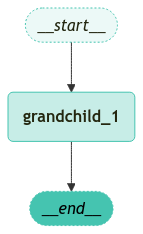

In [6]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(grandchild_graph, xray=True)

In [7]:
# Invoke the graph
for chunk in grandchild_graph.stream(
    {"my_grandchild_key": "Hi, Teddy!"}, subgraphs=True
):
    print(chunk)

((), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}})


## Definition of `child`
The `child graph` acts as an intermediary unit between the `parent graph` and the `grandchild graph`. It is responsible for managing its own `state` while interacting with the `grandchild graph`. The `child graph` ensures that input from the `parent` is transformed appropriately before invoking the `grandchild graph` and vice versa.

In [8]:
# TypedDict class definition for the child state type
class ChildState(TypedDict):
    my_child_key: str

# Invoke grandchild graph and state transition function,
# receive child state as input, and return transformed child state
def call_grandchild_graph(state: ChildState) -> ChildState:
    # Note: Parent or grandchild keys are not accessible here
    # Transform the child state to the grandchild state format
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    # Transform the grandchild state back to the child state format and return the result
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": f'([Child] {grandchild_graph_output["my_grandchild_key"]})'}


# Initialize child state graph
child = StateGraph(ChildState)
# Note: Pass the function instead of compiled graph
# Add nodes to the child graph and connect start-end edges
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
# Compile the child graph
child_graph = child.compile()

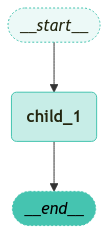

In [9]:
visualize_graph(child_graph, xray=True)

In [10]:
# Invoke the child_graph
for chunk in child_graph.stream({"my_child_key": "Hi, Teddy!"}, subgraphs=True):
    print(chunk)

(('child_1:01b9128c-41b6-667e-84f1-7f9647a303bc',), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}})
((), {'child_1': {'my_child_key': '([Child] ([GrandChild] Hi, Teddy!))'}})


The invocation of `grandchild_graph` is wrapped in a separate function (`call_grandchild_graph`).

This function transforms the input state before invoking the `grandchild_graph` and converts the output of the `grandchild_graph` back into the state format of the child graph.

If `grandchild_graph` is passed directly to `.add_node` without such a transformation, LangGraph will raise an error because there is no shared state key between the child and grandchild states.

**Important**

>Please note that the `child subgraph` and `grandchild subgraph` have their own **independent** `state` that is not shared with the `parent graph`.

## Definition of `parent`
The `parent graph` serves as the highest-level unit in the hierarchical graph system. It manages its own `state` and orchestrates the invocation of the `child graph`. The `parent graph` also ensures that its `state` is properly transformed to interact with the `child graph` and processes the resulting output.

This structure allows for a clear separation of responsibilities and ensures modularity in the overall design.

In [11]:
# TypedDict class definition for the parent state type
class ParentState(TypedDict):
    my_parent_key: str


# Transformation function that adds the string '[Parent1]' to the my_parent_key value of the parent state
def parent_1(state: ParentState) -> ParentState:
    # Note: Child or grandchild keys are not accessible here
    return {"my_parent_key": f'([Parent1] {state["my_parent_key"]})'}


# Transformation function that adds the string '[Parent2]' to the my_parent_key value of the parent state
def parent_2(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent2] {state["my_parent_key"]})'}


# Handles data transformation between parent and child states and invokes the child graph
def call_child_graph(state: ParentState) -> ParentState:
    # Transform the parent state channel (my_parent_key) into the child state channel (my_child_key)
    child_graph_input = {"my_child_key": state["my_parent_key"]}
    # Transform the child state channel (my_child_key) into the parent state channel (my_parent_key)
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_parent_key": child_graph_output["my_child_key"]}


# Initialize the parent state graph and configure nodes
parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)

# Note: Passing functions, not compiled graphs
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

# Configures edges to define the execution flow of the state graph
parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

# Compile the configured parent state graph into an executable graph
parent_graph = parent.compile()

Visualize the Graph.

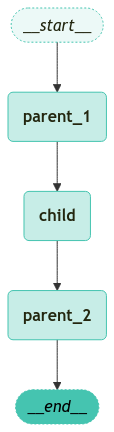

In [12]:
visualize_graph(parent_graph, xray=True)

The `child_graph` invocation is wrapped in a separate function `call_child_graph`, which transforms the input state before invoking the child graph and converts the child graph's output back into the parent graph's state.

If `child_graph` is passed directly to `.add_node` without transformation, LangGraph will throw an error due to the absence of shared state keys between the parent and child states.

Let's execute the parent graph to verify that the child and grandchild subgraphs are invoked correctly.

In [13]:
# Graph execution and passing the value "Hi, Teddy!" through the "my_parent_key" parameter
for chunk in parent_graph.stream({"my_parent_key": "Hi, Teddy!"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_parent_key': '([Parent1] Hi, Teddy!)'}})
(('child:38f2ab28-8c20-32b4-e7da-5acc2e64464e', 'child_1:614f7c7d-cac0-593a-c4c9-ebb3c07a998f'), {'grandchild_1': {'my_grandchild_key': '([GrandChild] ([Parent1] Hi, Teddy!))'}})
(('child:38f2ab28-8c20-32b4-e7da-5acc2e64464e',), {'child_1': {'my_child_key': '([Child] ([GrandChild] ([Parent1] Hi, Teddy!)))'}})
((), {'child': {'my_parent_key': '([Child] ([GrandChild] ([Parent1] Hi, Teddy!)))'}})
((), {'parent_2': {'my_parent_key': '([Parent2] ([Child] ([GrandChild] ([Parent1] Hi, Teddy!))))'}})
